#**Housing Market Tracker**












The purpose of this notebook is to set up a house prices tracking database of my cities of interest, based on Idealista data. This is the base algorythm I'll use to feed a future front end.



**1 - First, we import all the modules we'll need.**

In [ ]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup as bs
import matplotlib.pyplot as plt
import sqlite3
from datetime import date
import random
import time

**2 - We'll create an SQLite database to store all the data we'll scrap, and mark them with a timestamp that will be a key element to perform long-term analysis.**

In [ ]:
# We create the database and initialize the cursor.

connection = sqlite3.connect('idealista_data.db')
cursor = connection.cursor()

# Then we create the tables that will store all the data. In this case, price for sales and rentals.

# Sales table
cursor.execute("CREATE TABLE IF NOT EXISTS sales_data (id integer PRIMARY KEY, city text, timestamp text,  lowest_price real, highest_price real, average_price real, standard_deviation real, quartile_1 real, quartile_2 real, quartile_3 real);")
# Rentals table
cursor.execute("CREATE TABLE IF NOT EXISTS rentals_data (id integer PRIMARY KEY, city text, timestamp text, lowest_price real, highest_price real, average_price real, standard_deviation real, quartile_1 real, quartile_2 real, quartile_3 real);")
# Raw sales table 
cursor.execute("CREATE TABLE IF NOT EXISTS sales_raw (id integer PRIMARY KEY, city text, timestamp text, price real);")
# Raw rentals table
cursor.execute("CREATE TABLE IF NOT EXISTS rental_raw (id integer PRIMARY KEY, city text, timestamp text, price real);")


 **3 - Then we'll define the scraping function that will fetch the 
data related from the desired cities and store it in the database.**

In [ ]:
def scrap(list_of_cities : tuple, sales : bool = True): # Set sales to False if looking for rentals.

    headers = {
        
        'Host':'www.idealista.com',
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'es-ES,es;q=0.8,en-US;q=0.5,en;q=0.3',
        'Connection': 'keep-alive',
        'DNT': '1',
        'Sec-Fetch-Dest': 'document',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:100.0) Gecko/20100101 Firefox/106.0'}

    headers = {k: str(v).encode("utf-8") for k, v in headers.items()}  # Encode UTF-8
    cities = list_of_cities
    today = date.today()
    clean_date = today.strftime("%d/%m/%Y")

    for city in cities:
      try: 
        city_name= str(city.replace(" ", "-"))
        print(city_name)
        prices = []
        quartiles = []
        page = 1
        keep_search = True

        while keep_search:
            time.sleep(random.uniform(3,7))
            # URL constructor. Notice that they are only programmed to find the offers in province of Barcelona, otherwise you should change this part of the url.
            if sales:
              base_url = f"https://www.idealista.com/venta-viviendas/{city_name.lower()}-barcelona/pagina-{page}.htm?ordenado-por=precios-asc"
            else:
              base_url = f"https://www.idealista.com/alquiler-viviendas/{city_name.lower()}-barcelona/pagina-{page}.htm?ordenado-por=precios-asc"
            web = requests.get(base_url, headers=headers)
            print(f'Idealista server answer to {city_name} request: {web}')
            time.sleep(random.uniform(0.2, 0.4))
            soup = bs(web.content, 'html.parser')
            pricesoup = soup.findAll("span", attrs={"class", "item-price h2-simulated"})
            any_more = soup.findAll("li", attrs={"class", "next"}) #a, icon-arrow-right-after

            print(f"Extracting data from page {page}.") # Page check

            for price in pricesoup:  # First converts the price into string, removes dots, then it converts it into a float.
                new_price = str(price.contents[0])
                new_price2 = new_price.replace(".", "")
                new_price2 = float(new_price2)
                prices.append(new_price2)

            page+=1

            if len(any_more) == 0:  # If there's no next page, it stops the loop.
                keep_search = False
            print(prices)
            prices_df = pd.DataFrame(prices, columns=['price'])
            mean = float(prices_df['price'].mean().round(2))
            quartile_1 = prices_df.quantile([.25])
            quartile_1 = quartile_1['price']
            quartile_2 = prices_df.quantile([.5])
            quartile_2 = quartile_2['price']
            quartile_3 = prices_df.quantile([.75])
            quartile_3 = quartile_3['price']
            std_deviation = prices_df['price'].std()
            lowest_price = prices[0]
            highest_price = prices[-1]
        # Save clean data as general overview for a city, in a given timestamp
        if sales:
          cursor.execute("""INSERT INTO sales_data (city, timestamp, lowest_price, highest_price, average_price, standard_deviation, quartile_1, quartile_2, quartile_3) values (?, ?, ?, ?, ?, ?, ?, ?, ?);""", (city_name, clean_date, int(lowest_price), int(highest_price), int(mean), int(std_deviation), int(quartile_1), int(quartile_2), int(quartile_3)))
        else:
          cursor.execute("""INSERT INTO rentals_data (city, timestamp, lowest_price, highest_price, average_price, standard_deviation, quartile_1, quartile_2, quartile_3) values (?, ?, ?, ?, ?, ?, ?, ?, ?);""", (city_name, clean_date, int(lowest_price), int(highest_price), int(mean), int(std_deviation), int(quartile_1), int(quartile_2), int(quartile_3)))
         
        # Save raw prices data from a city, in a given timestap
        for price in prices_df['price']:
          item_price = int(price)
          if sales:
            cursor.execute("""INSERT INTO sales_raw (city, timestamp, price) values (?, ?, ?);""", (city_name, clean_date, item_price))
          else:
            cursor.execute("""INSERT INTO rentals_raw (city, timestamp, price) values (?, ?, ?);""", (city_name, clean_date, item_price))
        connection.commit()
        print(f'Sales data from {city_name} saved.')
      except:
        print(f'Failed to gather data from {city_name}.')
        continue

      print('Data extraction finished!')    

list_of_cities=('cerdanyola del valles', 'badia del valles') # Set your cities of interest
                
scrap(list_of_cities=list_of_cities) 

**At this point we have all the data stored in a portable SQLite database. Now we'll build functions to plot our data following diferent criteria:**


> - Function to plot the data of a city at specific date (bar plot).
> - Function to plot quartiles and scatter data of a city at specific date.
> - Function to plot the evolution of the prices of a city over time (basic plot)
> - Function to compare cities at specific date (bars).
> - Function to compare evolution of a set of cities over time (basic plot, or bars, etc.).






**1 - Plotting lowest, highest and average prices.**

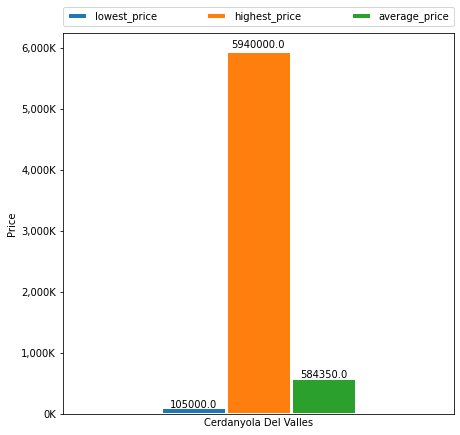

In [ ]:
def single_date_city_price(city : str, timestamp : str, sales : bool = True):
  
  if sales:
    data = cursor.execute('SELECT * FROM sales_data WHERE city = ? and timestamp = ? ;', (city, timestamp))
  else:
    data = cursor.execute('SELECT * FROM rentals_data WHERE city = ? and timestamp = ? ;', (city, timestamp))  
  results = cursor.fetchall()
  dataframe = pd.DataFrame(results)
  dataframe.columns = [description[0] for description in cursor.description]

  # Now we have a dataframe with all the data of a single day, with named columns, so we can play around with it.

  # Bar plot 

  clean_df = dataframe[['city','lowest_price', 'highest_price','average_price']]
  ax = clean_df.plot.bar(rot= 0, figsize=(7,7), edgecolor='white', linewidth=3)
  ax.legend(['Lowest price', 'Highest price', 'Average price'], loc=2)
  # Legend parameters
  l4 = ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

  # Show values
  
  for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/2  , p.get_height() * 1.01), ha='center', fontsize=10)

  # Clean name for the plot and assign it to X axis:

  raw_city_name = city
  clean_name = city.replace('-', ' ')
  plt.xlabel(f'{clean_name.title()}')
  plt.ylabel('Price')
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
  # Label thousand as K
  ylabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_yticks()/1000]
  ax.set_yticklabels(ylabels)
  plt.show()

single_date_city_price(city='cerdanyola-del-valles', timestamp = '13/11/2022')

**2 - Plotting prices of a city at a given timestamp**

**2.1 Scatter plot**

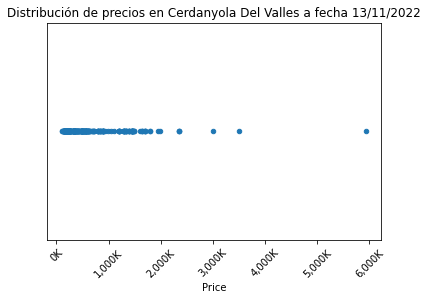

In [ ]:
def scatter(city : str, timestamp : str, sales : bool = True):

  if sales:
    data = cursor.execute('SELECT * FROM sales_raw WHERE city = ? and timestamp = ? ;', (city, timestamp))
  else:
    data = cursor.execute('SELECT * FROM rentals_raw WHERE city = ? and timestamp = ? ;', (city, timestamp))
  results = cursor.fetchall()
  dataframe = pd.DataFrame(results)
  dataframe.columns = [description[0] for description in cursor.description]

  # Now we have a dataframe with all the data of a single day, with named columns, like in the previous function.

  # Scatter plot

  clean_df = dataframe[['city','price', 'timestamp']]
  raw_city_name = city
  clean_name = city.replace('-', ' ')
  ax = clean_df.plot.scatter(x='price',y='city', rot=45)
  ax.legend(['Price'], loc=2)
  plt.title(f'Distribución de precios en {clean_name.title()} a fecha {timestamp}')
  plt.xlabel(f'Price')
  ax.axes.yaxis.set_visible(False) # remove y axis label since it is useless having the title
  ax.get_legend().remove()
  plt.tick_params(
    axis='y',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelleft=False,       
    labelbottom=False) # labels along the bottom edge are off

  xlabels = ['{:,.0f}'.format(x) + 'K' for x in ax.get_xticks()/1000]
  ax.set_xticklabels(xlabels)
 
scatter(city='cerdanyola-del-valles', timestamp = '13/11/2022')

**2.2 Quartiles boxplot**

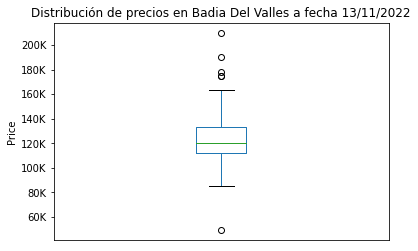

In [ ]:
def quartiles(city : str, timestamp : str, sales : bool = True):
  # Get all the data
  if sales:
    data = cursor.execute('SELECT * FROM sales_raw WHERE city = ? and timestamp = ? ;', (city, timestamp))
  else:
    data = cursor.execute('SELECT * FROM rentals_raw WHERE city = ? and timestamp = ? ;', (city, timestamp))
  results = cursor.fetchall()
  dataframe = pd.DataFrame(results)
  dataframe.columns = [description[0] for description in cursor.description]

  # Quartiles plot

  clean_df = dataframe[['city','price', 'timestamp']]
  quartile_1 = clean_df['price'].quantile([.25])
  quartile_2 = clean_df['price'].quantile([.5])
  quartile_3 = clean_df['price'].quantile([.75])
  raw_city_name = city
  clean_name = city.replace('-', ' ')

  quartiles = clean_df.boxplot(grid=False)
  quartiles.axes.xaxis.set_visible(False)
  plt.title(f'Distribución de precios en {clean_name.title()} a fecha {timestamp}')
  plt.ylabel('Price')

  # Formato para mostrar en miles (K)
  ylabels = ['{:,.0f}'.format(x) + 'K' for x in quartiles.get_yticks()/1000]
  quartiles.set_yticklabels(ylabels)

  plt.show()

quartiles(city='badia-del-valles', timestamp = '13/11/2022')

**2.3 Function to compare cities at specific date (basic plot, or bars).**

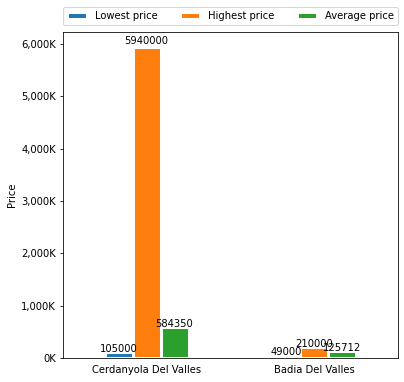

In [ ]:
def compare_prices_single_date(sales : bool = True):
  # Final version will receive a tuple of cities as an argument instead of an inner one
  cities = ('cerdanyola-del-valles', 'badia-del-valles')
  timestamp = '13/11/2022'
  data = pd.DataFrame(columns=['City', 'Lowest price', 'Highest price', 'Average price']) 

  # Gathering the data for each city

  for city in cities:
    clean_city = city.replace('-',' ')
    if sales:
      raw_data = cursor.execute('SELECT lowest_price, highest_price, average_price FROM sales_data WHERE city = ? and timestamp = ? ;', (city, timestamp)) 
    else:
      raw_data = cursor.execute('SELECT lowest_price, highest_price, average_price FROM rentals_data WHERE city = ? and timestamp = ? ;', (city, timestamp))          
    results = cursor.fetchall()
    low_price = int(results[0][0])
    high_price = int(results[0][1])
    average_price = int(results[0][2])
    new_row = {'City':clean_city.title(), 'Lowest price':low_price, 'Highest price':high_price, 'Average price':average_price}
    data = data.append(new_row, ignore_index = True)

  # bar plot
  plot = data.plot.bar(x='City', rot= 0, figsize=(6,6), edgecolor='white', linewidth=3)
  plot.legend(['Lowest price', 'Highest price', 'Average price'], loc=2)
  # Legend parameters
  l4 = plot.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=3)

  # Show values
  
  for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() + p.get_width()/2  , p.get_height() * 1.01), ha='center', fontsize=10)

  # Clean name for the plot and assign it to X axis:

  raw_city_name = city
  clean_name = city.replace('-', ' ')
  plt.xlabel('')
  plt.ylabel('Price')
  plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=True) # labels along the bottom edge are off
    
  # Formato para mostrar en miles (K)
  ylabels = ['{:,.0f}'.format(x) + 'K' for x in plot.get_yticks()/1000]
  plot.set_yticklabels(ylabels)

  plt.show()

compare_prices_single_date()



**2.4 Function to check evolution of prices over time in one city. Still have to be tested in future with more data stored.**

In [ ]:
def evol_single_city(city : str, timestamp_tuple : tuple, sales : bool = True):

  # Final version will receive a tuple of cities as an argument.
  city = ('cerdanyola-del-valles')
  timestamps = ('13/11/2022', 'Future new date')
  data = pd.DataFrame(columns=['City', 'Average price']) 
   
  # Gathering the data for each city

  for date in timestamps:
    clean_city = city.replace('-',' ')
    if sales:
      raw_data = cursor.execute('SELECT average_price FROM sales_data WHERE city = ? and timestamp = ? ;', (city, date))
    else:
      raw_data = cursor.execute('SELECT average_price FROM rentals_data WHERE city = ? and timestamp = ? ;', (city, date))    
    results = cursor.fetchall()
    average_price = int(results[0][0])
    new_row = {'City':clean_city.title(), 'Average price':average_price}
    data = data.append(new_row, ignore_index = True)
  
  # bar plot
  plot = data.plot(x='City', rot= 0, figsize=(6,6), edgecolor='white', linewidth=3)
  plot.legend(['Average price'], loc=2)

  # Show values
  
  for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() + p.get_width()/2  , p.get_height() * 1.01), ha='center', fontsize=10)

  # Clean name for the plot and assign it to X axis:

  raw_city_name = city
  clean_name = city.replace('-', ' ')
  #plt.xlabel(f'{clean_name.title()}')
  plt.ylabel('Price')
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
    
  # Format (K)
  ylabels = ['{:,.0f}'.format(x) + 'K' for x in plot.get_yticks()/1000]
  plot.set_yticklabels(ylabels)

  plt.show()
    
    


**2.5 Function to compare evolution of average prices over time between several cities. Test pending.**

In [ ]:
def evol_cities(cities : tuple, timestamp_tuple : tuple, sales : bool = True):

  # Final version will receive tuples as an argument, not a hardcoded city like in this example.
  city = ('cerdanyola-del-valles')
  timestamps = ('09/11/2022', 'Future new date')
  data = pd.DataFrame(columns=['City',  'Average price', 'date']) 

  # Gathering the data for each city and date

  for date in timestamps:
    for city in cities:
      clean_city = city.replace('-',' ')
      if sales:
          raw_data = cursor.execute('SELECT average_price FROM sales_data WHERE city = ? and timestamp = ? ;', (city, date))
      else:
          raw_data = cursor.execute('SELECT average_price FROM rentals_data WHERE city = ? and timestamp = ? ;', (city, date))  
      results = cursor.fetchall()
      average_price = int(results[0][2])
      new_row = {'City':clean_city.title(), 'Average price':average_price, 'date':date}
      data = data.append(new_row, ignore_index = True)
  
  # bar plot
  plot = data.plot(x='City', rot= 0, figsize=(6,6), edgecolor='white', linewidth=3)
  plot.legend(['Average price'], loc=2)

  # Show values
  
  for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() + p.get_width()/2  , p.get_height() * 1.01), ha='center', fontsize=10)

  # Clean name for the plot and assign it to X axis:

  raw_city_name = city
  clean_name = city.replace('-', ' ')
  #plt.xlabel(f'{clean_name.title()}')
  plt.ylabel('Price')
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
    
  # Format the y ticks to show thousands as K.
  ylabels = ['{:,.0f}'.format(x) + 'K' for x in plot.get_yticks()/1000]
  plot.set_yticklabels(ylabels)

  plt.show()
    
    


# **3 - Displaying size of the offer**

This could be, again, divided in many functions:

> - Size of offer of one or many cities in a single date.
> - Size of offer of one or many cities over time.

**3.1 Getting total offer of one or many cities in a given timestamp.**




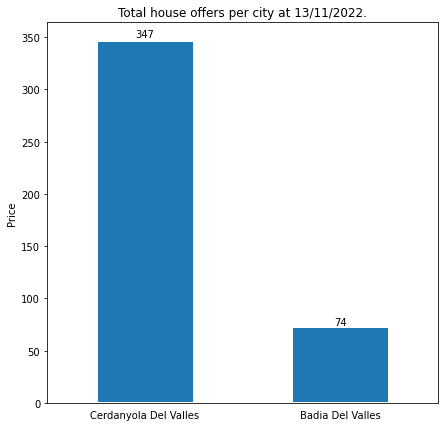

In [ ]:
def get_total_offer(cities : tuple, timestamp : str, sales : bool = True):

   cities = cities
   date = timestamp
   data = pd.DataFrame(columns=['City',  'Total offer', 'Date'])

   for city in cities:       
      # Gathering the data for each city and moment
      clean_city = city.replace('-',' ')
      # Distinction between sales or rentals.
      if sales:
        raw_data = cursor.execute('SELECT count(*) FROM sales_raw WHERE city = ? and timestamp = ? ;', (city, date))
      else:
        raw_data = cursor.execute('SELECT count(*) FROM rentals_raw WHERE city = ? and timestamp = ? ;', (city, date))
      results = cursor.fetchall()
      total_offer = int(results[0][0])
      new_row = {'City':clean_city.title(), 'Total offer':total_offer, 'Date':date}
      data = data.append(new_row, ignore_index = True)
 
   # Bar plot 

   ax = data.plot.bar(x='City',rot= 0, figsize=(7,7), edgecolor='white', linewidth=3, legend=False)

   # Show values
  
   for p in ax.patches:
     ax.annotate(str(p.get_height()), (p.get_x() + p.get_width()/2  , p.get_height() * 1.01), ha='center', fontsize=10)

   # Clean name for the plot and assign it to X axis:

   raw_city_name = city
   clean_name = city.replace('-', ' ')
   plt.title(f'Total house offers per city at {timestamp}.')
   plt.ylabel('Price')
   plt.xlabel('')
   plt.tick_params(
      axis='x',          # changes apply to the x-axis
      which='both',      # both major and minor ticks are affected
      bottom=False,      # ticks along the bottom edge are off
      top=False,         # ticks along the top edge are off
      labelbottom=True) # labels along the bottom edge are off

   plt.show()

list_of_cities=('cerdanyola-del-valles', 'badia-del-valles')
get_total_offer(cities=list_of_cities, timestamp='13/11/2022')

**3.2 Plotting evolution of cities offer over time.**

In [ ]:
def offer_evolution(cities : tuple, timestamp : tuple, sales : bool = True):

   cities = cities
   dates = timestamp
   data = pd.DataFrame(columns=['City',  'Total offer', 'Date'])
   # Gathering the data for each city and moment
   for timestamp in dates:
      for city in cities:       
          clean_city = city.replace('-',' ')
          # Distinction between sales or rentals.
          if sales:
            raw_data = cursor.execute('SELECT count(*) FROM sales_raw WHERE city = ? and timestamp = ? ;', (city, date))
          else:
            raw_data = cursor.execute('SELECT count(*) FROM rentals_raw WHERE city = ? and timestamp = ? ;', (city, date))
          results = cursor.fetchall()
          total_offer = int(results[0][0])
          new_row = {'City':clean_city.title(), 'Total offer':total_offer, 'Date':date}
          data = data.append(new_row, ignore_index = True)

  # bar plot
  plot = data.plot(x='City', rot= 0, figsize=(6,6), edgecolor='white', linewidth=3)
  plot.legend(['Average price'], loc=2)

  # Show values
  
  for p in plot.patches:
    plot.annotate(str(p.get_height()), (p.get_x() + p.get_width()/2  , p.get_height() * 1.01), ha='center', fontsize=10)

  # Clean name for the plot and assign it to X axis:

  raw_city_name = city
  clean_name = city.replace('-', ' ')
  #plt.xlabel(f'{clean_name.title()}')
  plt.ylabel('Price')
  plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=True) # labels along the bottom edge are off
    
  # Format the y ticks to show thousands as K.
  ylabels = ['{:,.0f}'.format(x) + 'K' for x in plot.get_yticks()/1000]
  plot.set_yticklabels(ylabels)

  plt.show()
 